This notebook presents the implementation of our project.
Please visit our github at  https://github.com/sdorsetti/DL_SBGMproject/tree/main

# INSTALLATIONS, IMPORTATIONS AND CLONE PACKAGES

In [1]:
!pip install pretty_midi
!git clone https://github.com/sdorsetti/DL_SBGMproject.git

     |████████████████████████████████| 5.6 MB 12.5 MB/s 
     |████████████████████████████████| 51 kB 5.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=62f2508f54a8cc3775b73e7813e01ef466ce418a481deb99ac561f3c70c4d385
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Cloning into 'DL_SBGMproject'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 313 (delta 11), reused 28 (delta 5), pack-reused 275
Receiving objects: 100% (313/313), 92.43 MiB | 25.44 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [2]:
#@title Imports
####GENERAL
import pretty_midi
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import functools
from sklearn.decomposition import PCA

###TORCH
import torch.nn as nn
from torch.nn.functional import softplus
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
from torch import optim
from torch.autograd import Variable
from torch.optim import Adam


######VISUALISATION
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image, Audio, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns

In [3]:
from DL_SBGMproject.VAE.torch_data import *
from DL_SBGMproject.VAE.VAE import VariationalAutoencoder
from DL_SBGMproject.MidiFile.midi_file import MidiFileParser
from DL_SBGMproject.structure import data_path,data_midi_path, data_output_path
from DL_SBGMproject.utils.utils import *

# ENCODING 

First, we would like to encode the midi files conteined in the folder data. 
For this purpose, we want to parse them and encode them into numpy arrays. We use the library pretty-midi for this purpose. We extrat the piano rolls and obtain arrays with the time frame corresponding to the row  dimensions and the keys of a keyboard as columns. The values corresponds to the intensity at which the note was played. 
Many process functions can be considered starting from there, knowing transposing all notes to the same key, scale all values to the same number, decompose the left hand and the right hand, considering them as different music pieces, or join them together. We tested the different processes to get the best encoding of the midi file. The music is also decomposed into bars, and the bars into notes. During the encoding process, the algorithm iterates on small time steps of the music and check which notes are played at this time. 
We can then build batches in which small samples of the music are stored, defined as the number of bars considered and the number of notes in each bars.

In [4]:
#@title Encoding in csv files.
#@markdown There is no need to run this cell because the csv are already stored in the data_csv_files subfolder in the repository. However, if one wants to manipulates the parameters and test other encoding version, it can be uncommented and ran very easaly. Depending on the parameter, and particularly the resolution parameter fs, and of course the size of the different music pieces and their nnumber in the forlder, it can take from few minutes to several hours...

path_to_midi = f"{data_midi_path}Piano Sonatas/"  #@param  {'type':'string'}
path_to_output = f"{data_output_path}" #@param  {'type':'string'}
fs =  8#@param {"type":"integer"}
logging_ = True #@param {"type":"boolean"}
transposer_ = True #@param {"type":"boolean"}
chopster_  = False #@param {"type":"boolean"}
trim_blanks_  = False #@param {"type":"boolean"}
minister_  = False #@param {"type":"boolean"}
arpster_  = False #@param {"type":"boolean"}
cutster_  = False #@param {"type":"boolean"}
padster_  = False #@param {"type":"boolean"}


# mfp = MidiFileParser(path_to_midi, logging=logging_)
# mfp.get_piano_roll_df(path_to_output, 
#                       fs, 
#                       transposer_,
#                       chopster_, 
#                       trim_blanks_, 
#                       minister_,
#                       arpster_, 
#                       cutster_, 
#                       padster_)


## CSV FILE

We can import the piano rolls df outputed from the previous encoding

In [5]:
!unzip /content/DL_SBGMproject/data/data_csv_file/encoded.zip -d /content/DL_SBGMproject/data/data_csv_file/ 

Archive:  /content/DL_SBGMproject/data/data_csv_file/encoded.zip
  inflating: /content/DL_SBGMproject/data/data_csv_file/encoded.csv  


In [6]:
csv_path = f"{data_output_path}encoded.csv"
df = pd.read_csv(csv_path, sep=";")

Let's see how it looks like :

In [7]:
print(f'There are {len(df)} lines in the dataframe')

There are 427927 lines in the dataframe


In [8]:
print(f"There are {len(df.iloc[:,0].unique())} files that were computed and each file is decomposed in {len(df.iloc[:,1].unique())} time steps (for the longest)")

There are 85 files that were computed and each file is decomposed in 11825 time steps (for the longest)


The number of files is explained by the fact that Mozart composed 19 sonates and duet piano and four-hands sonatas, often split in 3 movements. Each movement is decomposed itsled into many instrument object read by pretty-midi, often corresponding to the right-hand and the left-hand played by the pianist. Each hand is therefore computed as a particular piano piece.
The file names are in the format f'{name_of_sonatas}:{hand part}'
We can therefore easaly group the hand parts of the same piece by very simply groupping the df slice with same name_of_sonatas and suming over these slices

In [9]:
 df[df[df.columns[0]].str.contains("K331")].iloc[:,0].unique()

array(['K331 Piano Sonata n11 .mid_18:0',
       'K331 Piano Sonata n11 .mid_18:1',
       'K331 Piano Sonata n11 .mid_18:2',
       'K331 Piano Sonata n11 .mid_18:3',
       'K331 Piano sonata n11 3mov.mid_19:0',
       'K331 Piano sonata n11 3mov.mid_19:1'], dtype=object)

In [10]:
 alla_turca = df[df[df.columns[0]].str.contains("K331 Piano sonata n11 3mov.mid_19")]

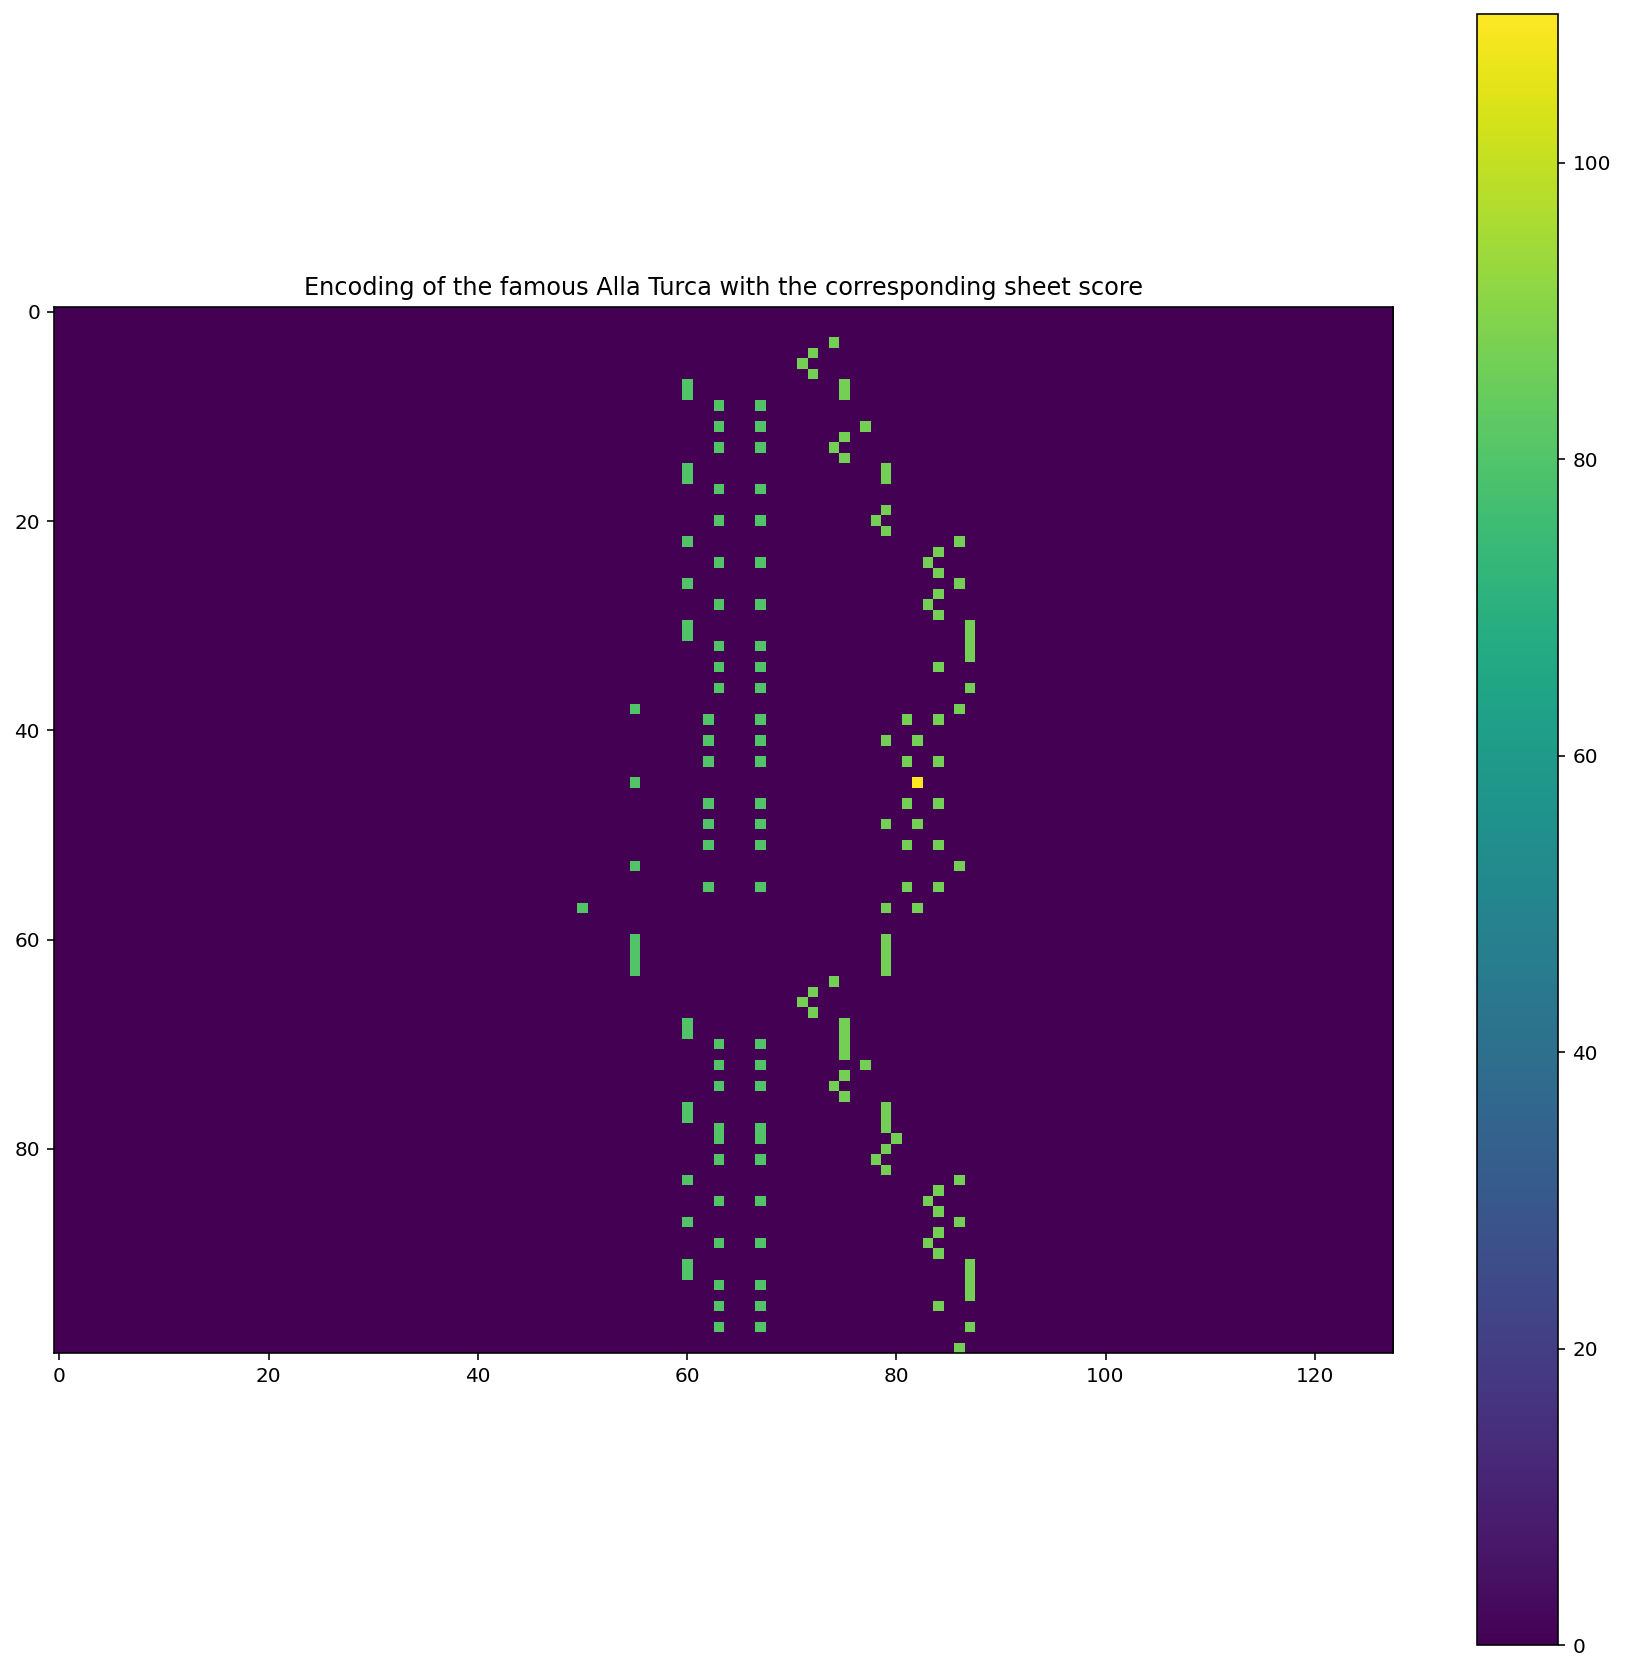

In [11]:
alla_turca2 = alla_turca.copy()
alla_turca2["file"] = alla_turca[alla_turca.columns[0]].apply(lambda x :x.split(":")[0])
plt.figure(figsize=(15,15))
plt.imshow(alla_turca2.groupby(["file", "0"]).sum().iloc[:100,:])
plt.title("Encoding of the famous Alla Turca with the corresponding sheet score")
plt.colorbar()
plt.show()

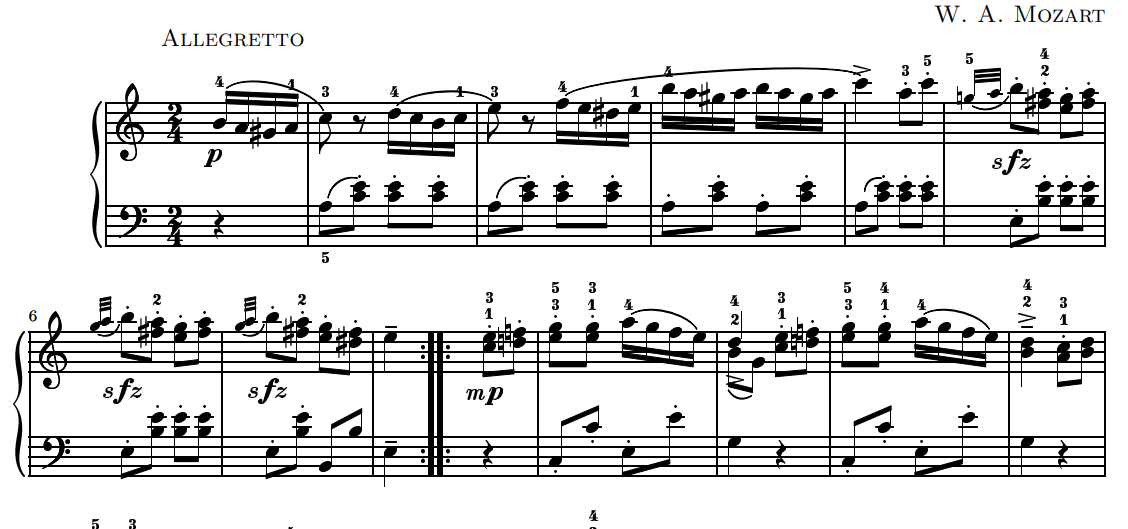

# Projection in latent space : VAEs

## Datalaoder

In [ ]:
#@title Load data with pytorch
#@markdown This cell builds torch loaders by building batches in which small samples of the music are stored, defined as the number of bars considered and the number of notes in each bars. If the slice happens to be uncomplete, for example at the end of the piece, we pad the remaining part with zeros. 
notesperbar= 8  #@param  {'type':'integer'}
totalbars =  16#@param  {'type':'integer'}
batch_size =  32#@param  {'type':'integer'}
num_workers = 2 #@param  {'type':'integer'}
test_split = .2 #@param  
shuffle = True #@param  {'type':'boolean'}
group_both_hands = True #@param {"type":"boolean"}


NUM_PITCHES= df.shape[1] - 2 + 1 #All notes played, so the columns of df minus the columns for filename and time step. We add an aditionnal column for silences.
TOTAL_NOTES=notesperbar*totalbars
num_features=NUM_PITCHES

transform = BarTransform(split=notesperbar,
                         bars=totalbars, 
                         note_count=NUM_PITCHES)
midi_dataset = MidiDataset(csv_file=csv_path, 
                           transform = transform, 
                           midi_start = 0,
                           midi_end = NUM_PITCHES - 1,
                           group_both_hands = group_both_hands) 


midi_dataset.get_mem_usage()
random_seed = 42
np.random.seed(random_seed)
    
dataset_size = len(midi_dataset)           
test_size = int(test_split * dataset_size) 
train_size = dataset_size - test_size      


train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, 
                          shuffle=shuffle, 
                          batch_size=batch_size, 
                          num_workers=num_workers,
                          drop_last=True)
test_loader = DataLoader(test_dataset, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers, 
                         drop_last=True)

print("Train size: {}, Test size: {}".format(train_size, test_size))


Train size: 1077, Test size: 269


In [ ]:
next(iter(train_loader))["piano_rolls"].shape
#(batchsize / notesperbar*totalbars /number of possible played notes + 1 for the silence)

torch.Size([32, 128, 129])

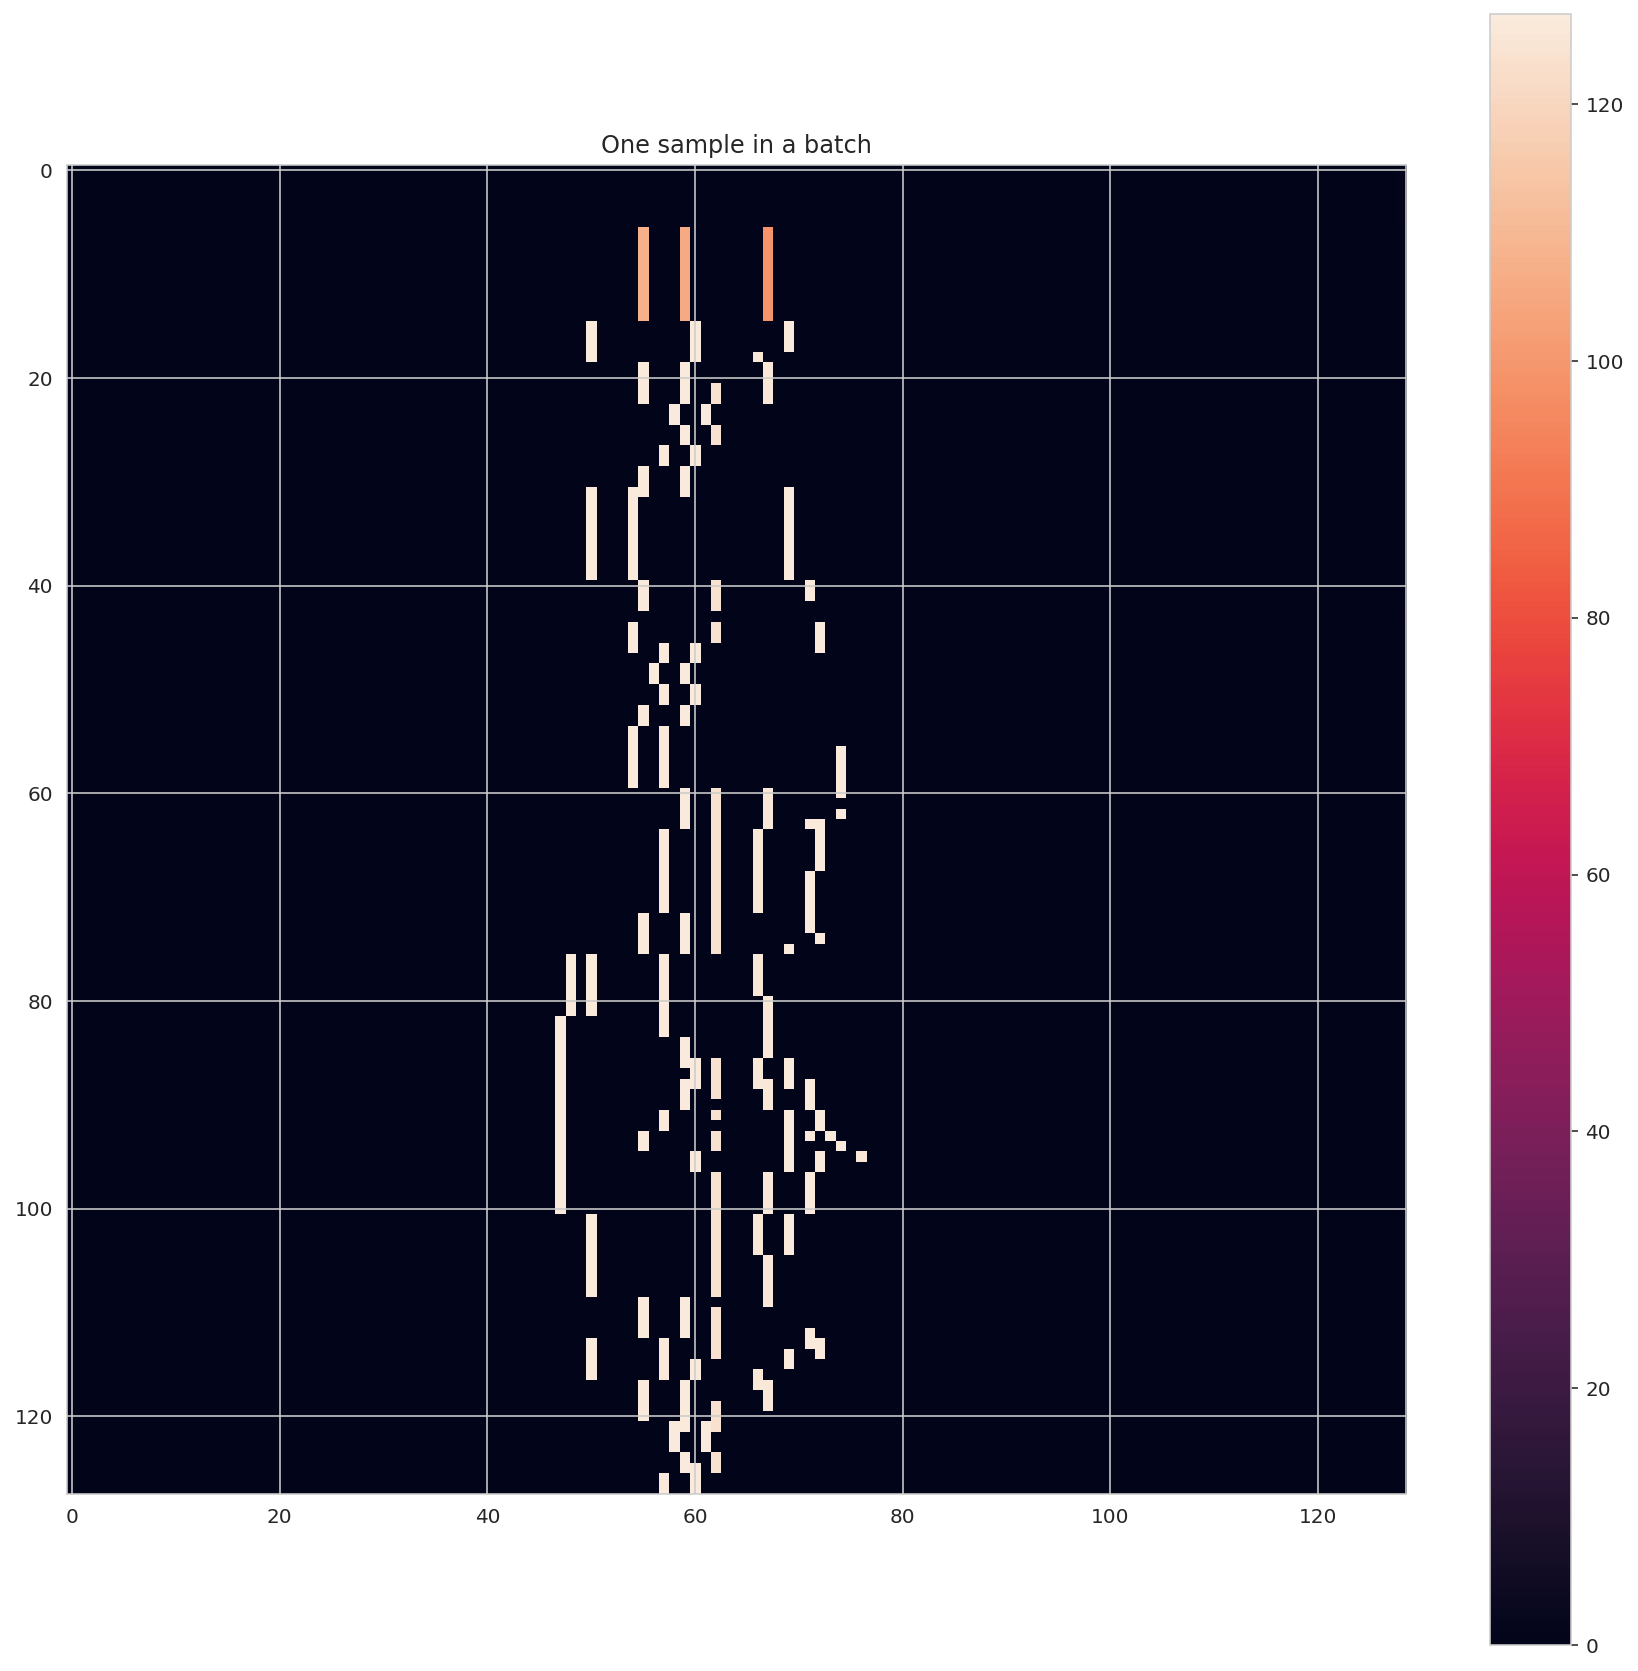

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(next(iter(train_loader))["piano_rolls"][31,:,:])
plt.title("One sample in a batch")
plt.colorbar()
plt.show()

## Training

In [ ]:
#@title Loading checkpoint
#@markdown This cell will load the checkpoints of a pretrained model on the mozart piano sonatas dataset. To load them, one needs to put the name of the checkpoint as parameter, as it is stored in the data folder of the repository. However, if one wants to train on another dataset, or with the same midi files but other encoding etc..., the checkpoints name in paramters just needs to be changed and this cell will automatically train a new VAE with the other parameters and save new checkpoints associated to this training, with the name passed in input. The current pretrained checkpoint are issued from a training with the following default parameters. Therefore, if one changed parameters and not the path to pretrained_model, it will load checkpoints with shapes not corresponding with the parameters passed in input and will therefore raise an error. So either change the path and the parameters, or the path only, BUT NOT keep the same path and change parameters 
pretrained_model = "model_mozart_sonatas_VAE.pt" #@param {"type":"string"}
latent_features = "64" #@param {"type" : "string"} ["64", "32", "128","DO NOT CHANGE UNLESS THE PRETRAINED MODEL ARGS WAS CHANGED"]
latent_features = int(latent_features)
enc_hidden_size = "256" #@param{"type" : "string"} ["256", "128","DO NOT CHANGE UNLESS THE PRETRAINED MODEL ARGS WAS CHANGED"]
enc_hidden_size = int(enc_hidden_size)
decoders_initial_size = 32 #@param{"type" : "string"} ["16", "32", "64", "DO NOT CHANGE UNLESS THE PRETRAINED MODEL ARGS WAS CHANGED"]
decoders_initial_size = int(decoders_initial_size)
dropout_rate = 0.2#@param
lr = 0.001 #@param
eps_i = 1 #@param
num_epochs = 100 #@param
teacher_forcing = True #@param {"type":"boolean"}

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

vae = VariationalAutoencoder(latent_features = latent_features, 
                             teacher_forcing = teacher_forcing, 
                             eps_i = eps_i, 
                             cuda = cuda, 
                             device = device,
                             enc_hidden_size = enc_hidden_size,
                             decoders_initial_size = decoders_initial_size,
                             dropout_rate = dropout_rate,
                             NUM_PITCHES=NUM_PITCHES,
                             totalbars = totalbars,
                             notesperbar = notesperbar).to(device)

path_to_pretrained = f"{data_path}{pretrained_model}"
if os.path.exists(path_to_pretrained):
  checkpoint = torch.load(path_to_pretrained)
  vae.load_state_dict(checkpoint)
else: 
  optimizer = optim.Adam(vae.parameters(), lr=lr)
  train_loss, train_kl, train_klw, valid_loss, valid_kl = vae.train_VAE(optimizer, 
                                                                        train_loader, 
                                                                        test_loader,
                                                                        path_to_pretrained, 
                                                                        num_epochs=num_epochs)


100%|██████████| 100/100 [39:50<00:00, 23.90s/it]

Finished. Time elapsed: 2390.2360920906067 seconds


# SBGM

We now want to implement the Score Based Generative Model. For this purpose, we inspirer ourselves from the implementation of Yang et all. but we changed the training process by implementing the forward process of the VAE encoding. 
So we firstly define the SDE that will perturb our data

To see the process, we can decompose it for a given sample of sound. 
First we create a new dataloader for the generative model

In [ ]:
#@title DataLoader Creation

batch_size = 32 #@param {"type":"integer"}
num_workers = 4 #@param {"type":"integer"}
shuffle = True #@param {"type":"boolean"}
drop_last = True #@param {"type":"boolean"}


data_loader = DataLoader(midi_dataset, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

In [ ]:
x = next(iter(data_loader))
x = Variable(x['piano_rolls'].type('torch.FloatTensor'))
x = x.to(device)
print("x is a tensor of shape {} ie 1.the batch size, 2.the number of bar and notes per bar, 3.the number of notes that can be played".format(x.shape))

x is a tensor of shape torch.Size([32, 128, 129]) ie 1.the batch size, 2.the number of bar and notes per bar, 3.the number of notes that can be played


And now we can perturb x using the following SDE :     
\begin{align*}
d \mathbf{x} = \sigma^t d\mathbf{w}, \quad t\in[0,1]
\end{align*}

In [ ]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)
  
sigma = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

Let's see the difference between the perturbed x and the original x

In [ ]:
builder = MidiBuilder()

In [ ]:
def perturbed_x_visualisation(x,t,sigma):

  x = torch.reshape(x, (batch_size, 1, totalbars*notesperbar, NUM_PITCHES))

  z = torch.randn_like(x)
  std = marginal_prob_std(t,sigma)
  perturbed_x = x + z * std[:, None, None, None]

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  fig.suptitle('Difference between original x and perturbed x, sigma = {}'.format(sigma))
  ax1.imshow(x.detach().cpu().numpy()[0,0,:256,48:108])
  ax1.set_title("Original x")
  ax2.imshow(perturbed_x.detach().cpu().numpy()[0,0,:256,48:108])
  ax2.set_title("Perturbed x")

In [ ]:
eps = 1e-5
t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



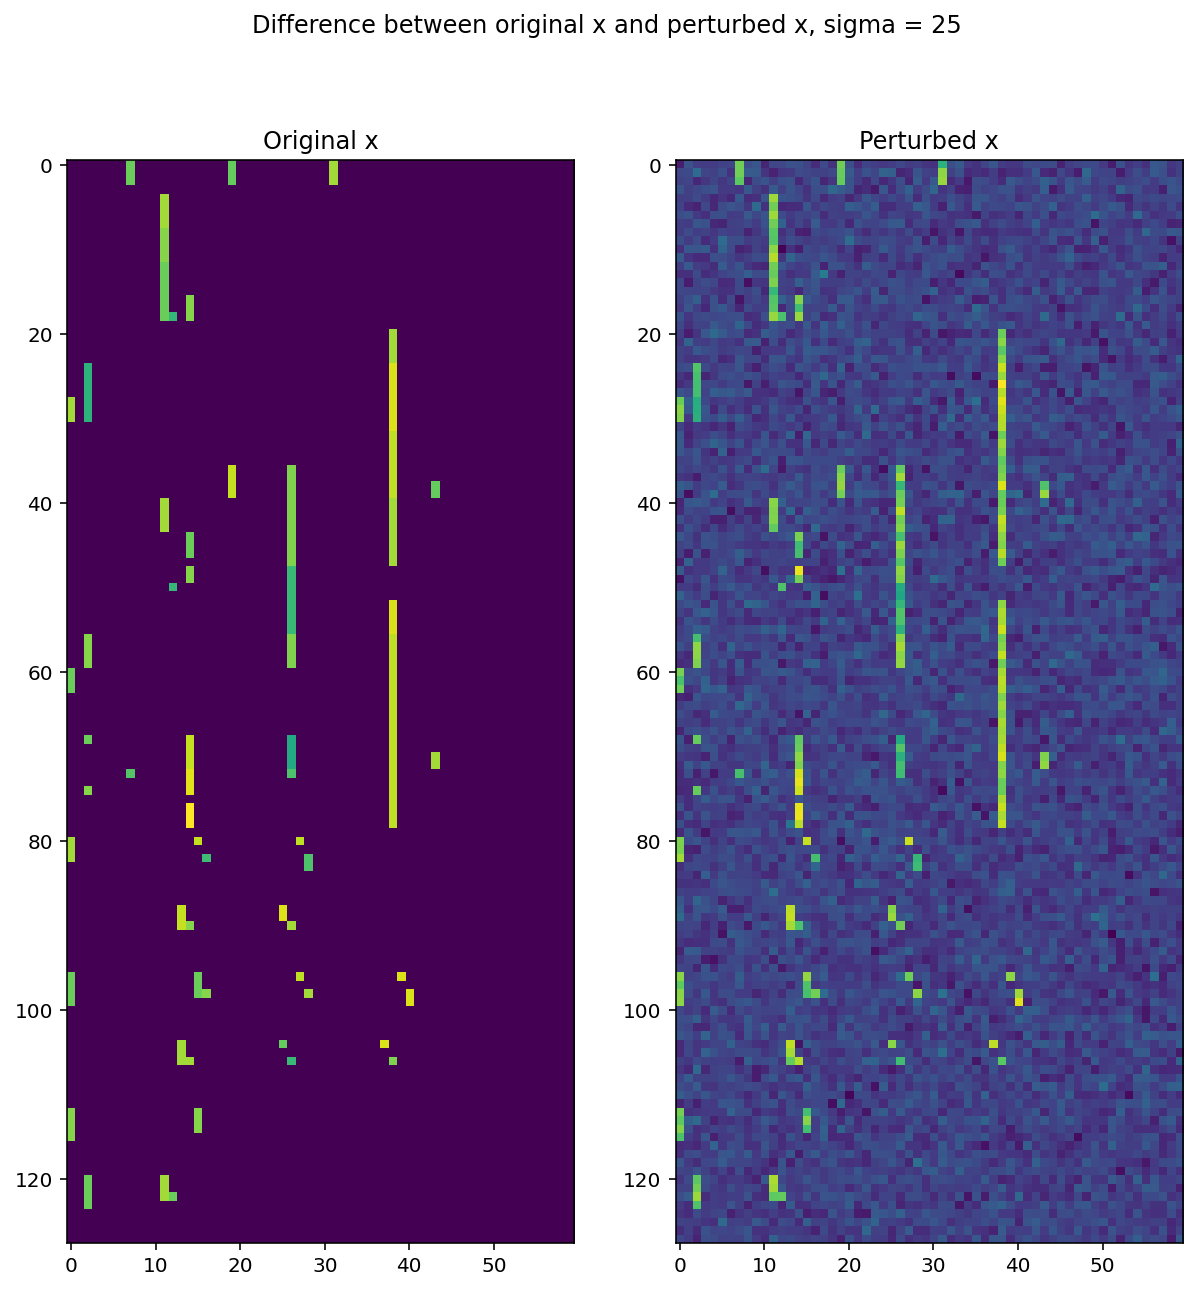

In [ ]:
perturbed_x_visualisation(x,t,sigma = 25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



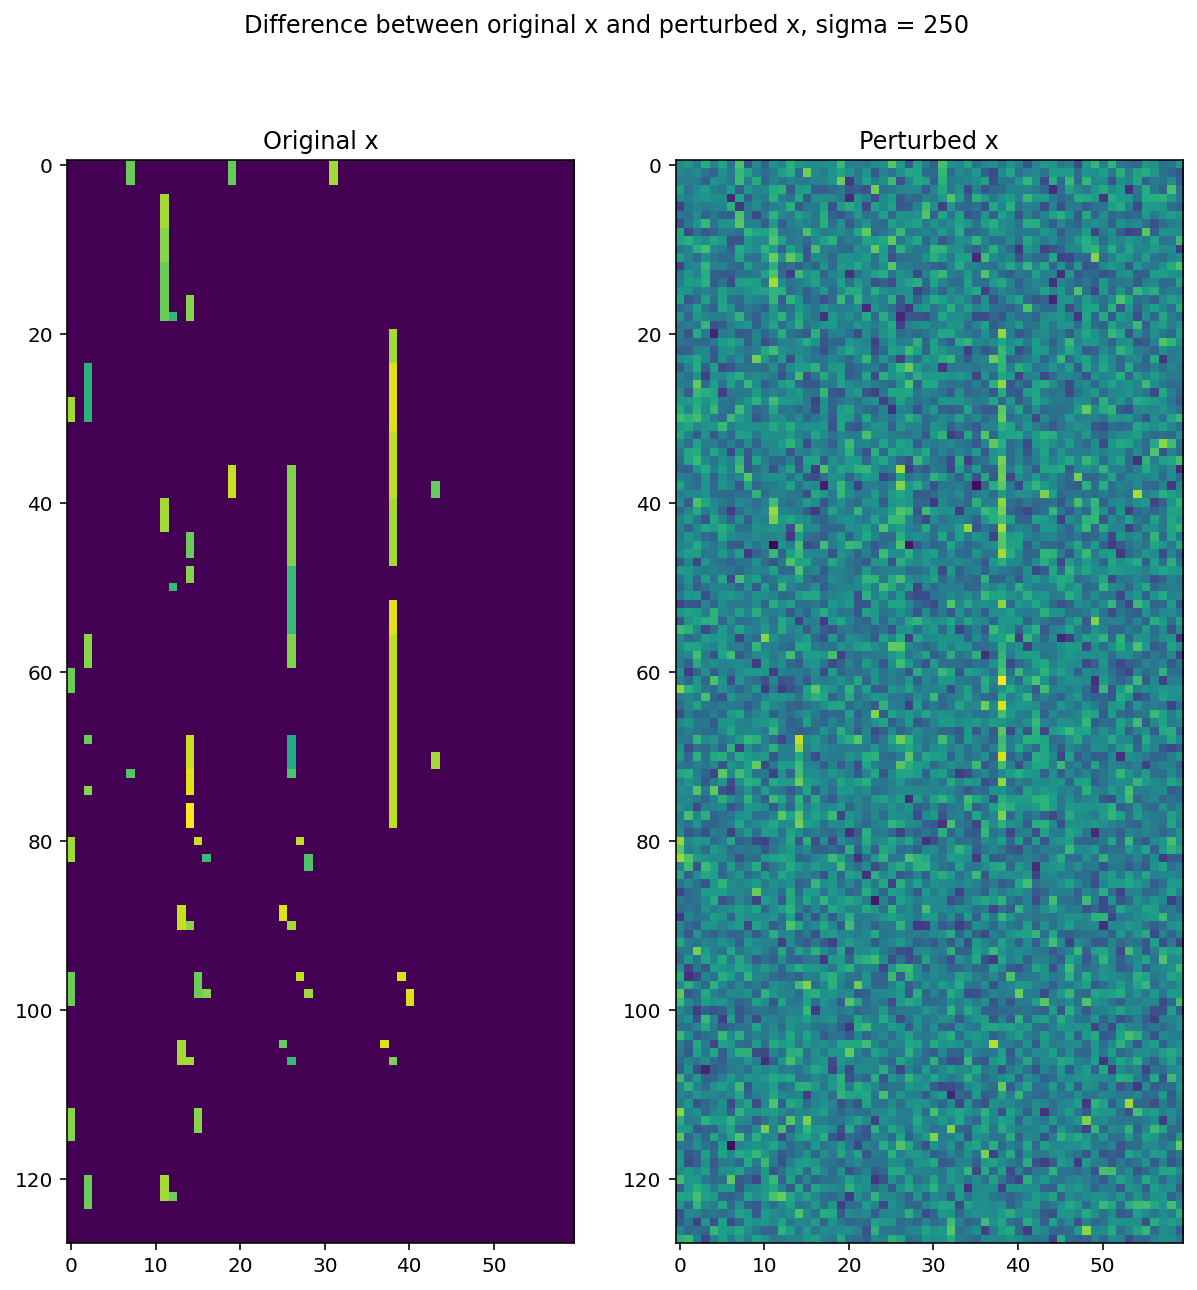

In [ ]:
perturbed_x_visualisation(x,t,sigma = 250)

Now we project this array in the latent space with the forward propagation trained of the VAE

In [ ]:
vae.set_scheduled_sampling(1.)
outputs = vae(x,notesperbar,totalbars)
z_latent = outputs['z'].detach()   
print(z_latent.shape)

torch.Size([32, 128, 32])


Now we define the networds that wil train our score model on the score function

In [ ]:
#@title Networks

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2,output_padding =1 , bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h
    


We can now define our loss, based on Yang et al. The idea is to build a score in the forward propagation of a U-net and approximating the real score function by minimizing the following loss
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2].
\end{align*}

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
#score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
score_model

DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense3): Dense(
      (dense): Linear(in_features=256, out_features=128, bias=True)
    )
    (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense4): Dense(
      (dense): Linear(in_features=256, out_features=256,

In [ ]:
#@title reverse SDE learning

batch_size = 32 #@param {"type":"integer"}
num_workers = 4 #@param {"type":"integer"}
lr=1e-4 #@param 
n_epochs =  50#@param
path_to_SBGM_pretrained= "SBGM_test_Mozart.pth" #@param {"type": "string"}
shuffle = True #@param {"type":"boolean"}
drop_last = True #@param {"type":"boolean"}

data_loader = DataLoader(midi_dataset, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers, 
                         drop_last=drop_last)

if not os.path.exists(data_path + path_to_SBGM_pretrained):
    
  optimizer = Adam(score_model.parameters(), 
                  lr=lr)
  import tqdm
  tqdm_epoch = tqdm.notebook.trange(n_epochs)
  for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
      x = Variable(x['piano_rolls'].type('torch.FloatTensor'))
      x = x.to(device)
      vae.set_scheduled_sampling(1.)
      outputs = vae(x,notesperbar,totalbars)
      z_latent = outputs['z'].detach()   
      z_latent = torch.reshape(z_latent, (batch_size, 1, totalbars*notesperbar, 32))
      loss = loss_fn(score_model, z_latent, marginal_prob_std_fn)
      optimizer.zero_grad()
      loss.backward()    
      optimizer.step()
      avg_loss += loss.item() * z_latent.shape[0]
      num_items += z_latent.shape[0]
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), data_path + path_to_SBGM_pretrained)

# SAMPLING : EULER-MARUYAMA

In [ ]:
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff,                          
                           num_steps,
                           batch_size=64, 
                           device='cuda', 
                           eps=1e-3):
  
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.  
  """

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 8*8, 32, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x



In [ ]:
#@title Sampling

num_steps =  500 #@param
sample_batch_size = 64 #@param
path_to_SBGM_pretrained= "SBGM_test_Mozart.pth" #@param {"type": "string"}

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
ckpt = torch.load(data_path + path_to_SBGM_pretrained, map_location=device)
score_model.load_state_dict(ckpt)
sampler = Euler_Maruyama_sampler 

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  batch_size = sample_batch_size, 
                  num_steps = num_steps,
                  device=device)
samples = torch.squeeze(samples)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Now let's see how those samples look like:

In [ ]:
samples.shape 

torch.Size([64, 64, 32])

These samples are in the latent space. They are generated samples from z. We need therefore to decode them. 

In [ ]:
data_loader = DataLoader(midi_dataset, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)#, sampler=train_sampler)
x = next(iter(data_loader))
x = Variable(x['piano_rolls'].type('torch.FloatTensor'))
notes_gen = vae.decode_VAE(x[0:1], samples[0:1],gen_batch=1, NUM_PITCHES = NUM_PITCHES,totalbars = totalbars, notesperbar = notesperbar)

In [ ]:
notes_gen[0,:,:].shape == x[0,:,:].shape

True

We are now in the original space [time x n_pitches]

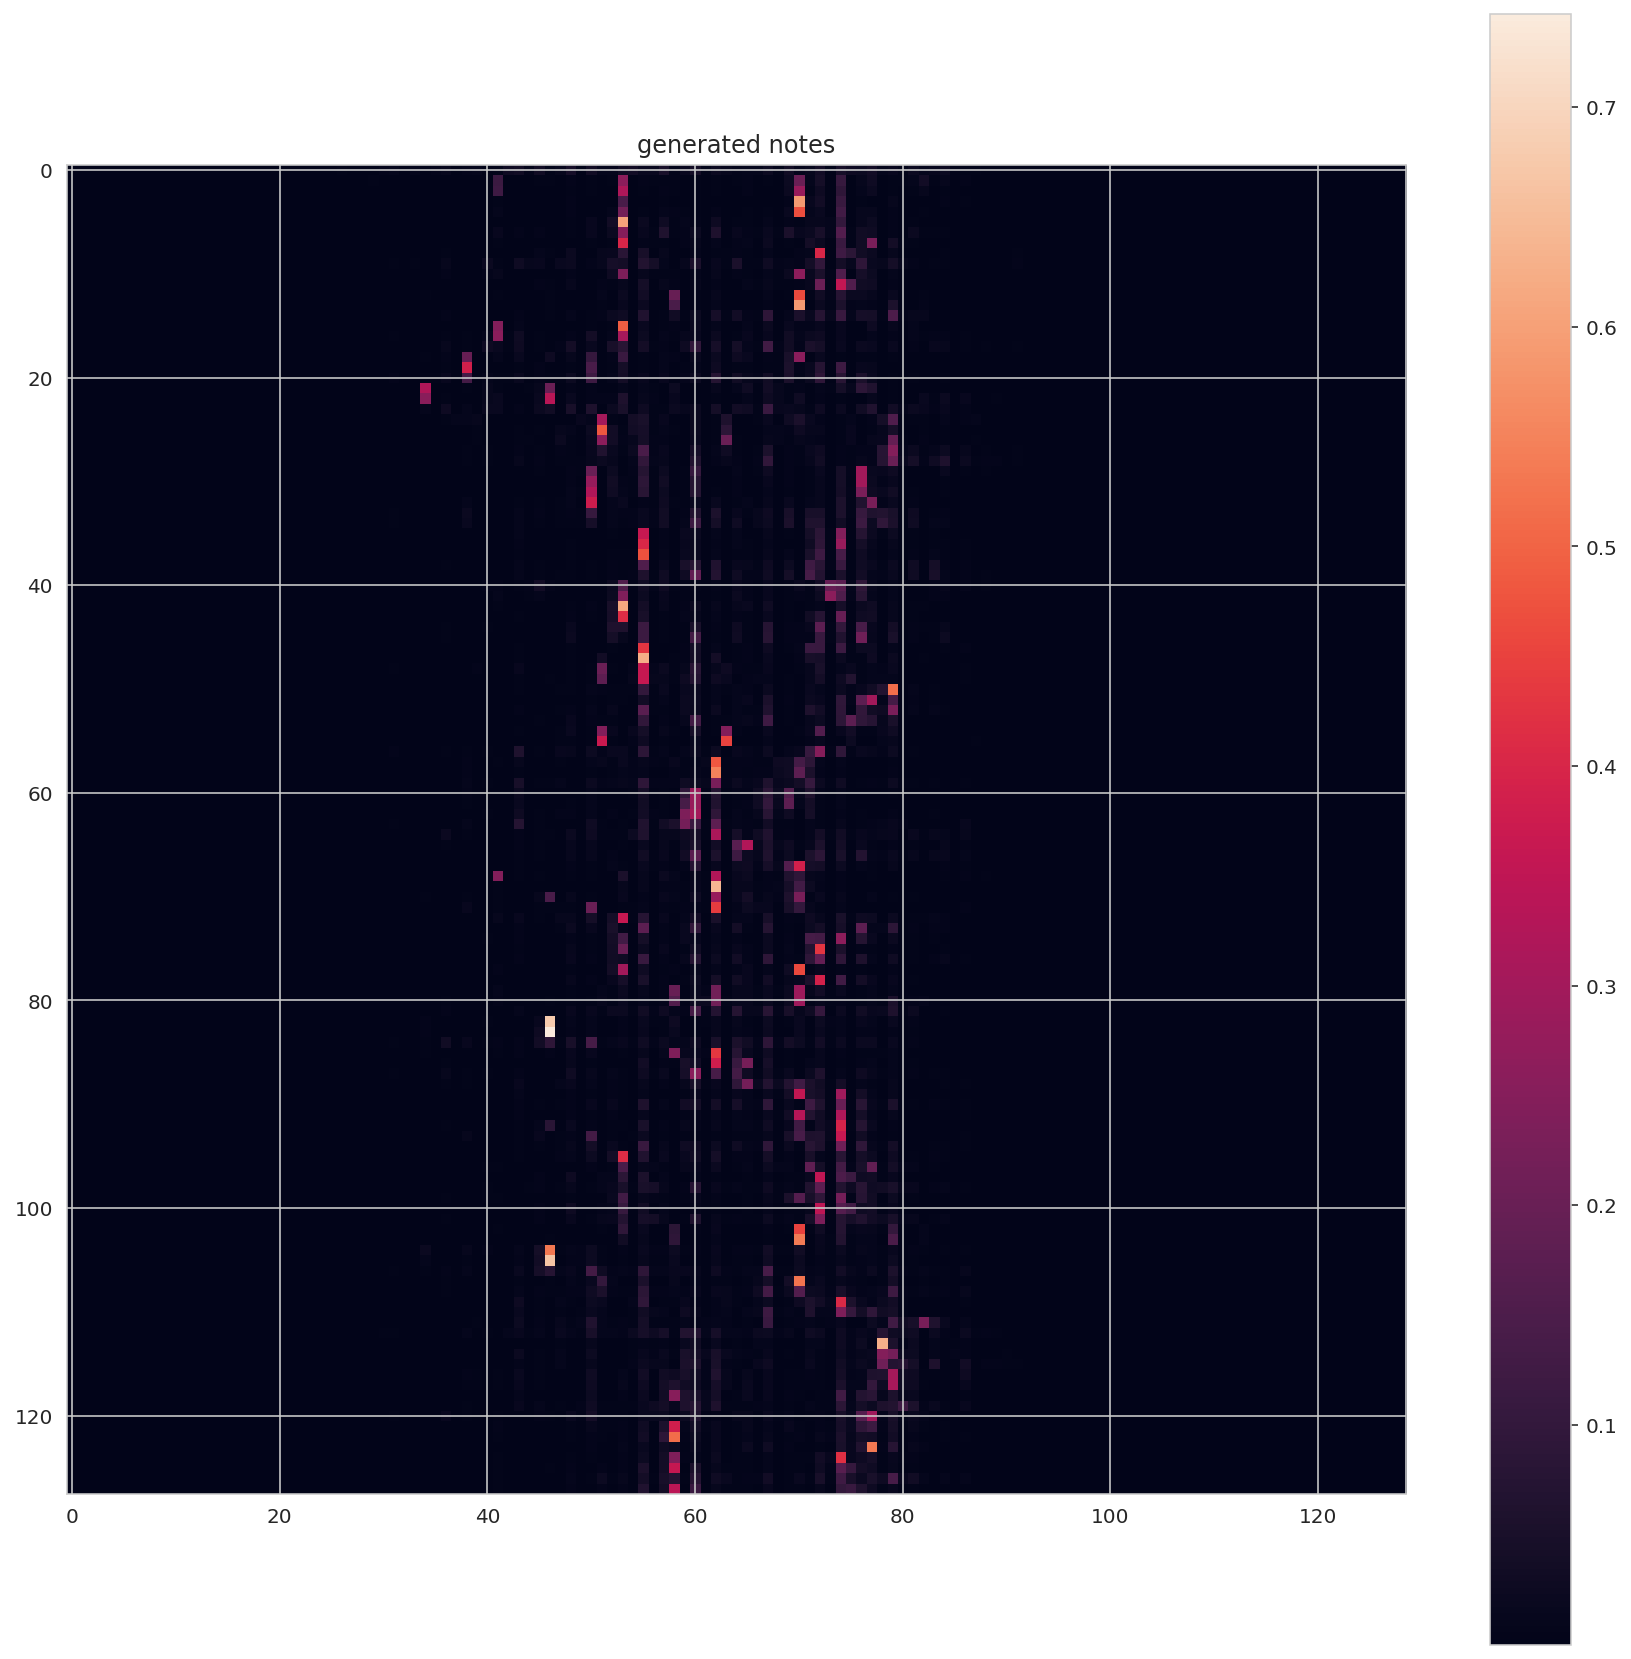

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(notes_gen.detach().cpu().numpy()[0,:,:])
plt.title("generated notes")
plt.colorbar()
plt.show()

We can now look at what do the generated notes look like. We see that there are densities zones. We need to find a decision rule that allow us to choose which note to keep on each row.We would like to think about a rule decision that enables to keep important value for each time frame. We can also consider keeping only the highest value, which will generate one-note-per-time melodies

In [ ]:
j = 10
seq = notes_gen.detach().cpu().numpy()
fig = go.Figure([go.Bar(x=np.arange(seq.shape[-1]), y=seq[0,j,:])])
fig.add_hline(y = np.sqrt(np.std(seq[0,j,:])))
fig.update_layout(title = "Keeping all notes whose value is grater to the variance at line {}".format(j))
fig.show()

In [ ]:
#@title Implementation of the threshold
def threshold(x):
  rows, columns = x.shape
  out = np.empty((rows, columns))
  for i in range(rows): 
    var = np.sqrt(np.std(x[i,:]))
    
    for j in range(columns) :
      if x[i,j] > var:
        out[i,j] = 127
      else : 
        out[i,j] = 0
  return out


In [ ]:
#@title Visualisation Function
def Play_midi(x,decode,TO_MID,FILENAME) :
  seq = x.detach().cpu().numpy()
  if decode : 
    midi_out = threshold(seq)
    midi = piano_roll_to_pretty_midi(midi_out[:,:-1],fs=8,to_mid = TO_MID, filename = FILENAME)
  else : 
    midi = piano_roll_to_pretty_midi(seq[:,:-1],fs=8,to_mid = TO_MID, filename = FILENAME)
  plt.figure(figsize=(10, 3))
  if decode : 
    plt.title("Midi_Generated")
  else : 
    plt.title("Midi_Original")
  builder.plot_midi(midi)
  synth, rate = builder.play_midi(midi)
  return(Audio(synth, rate=rate))

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning:

Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?



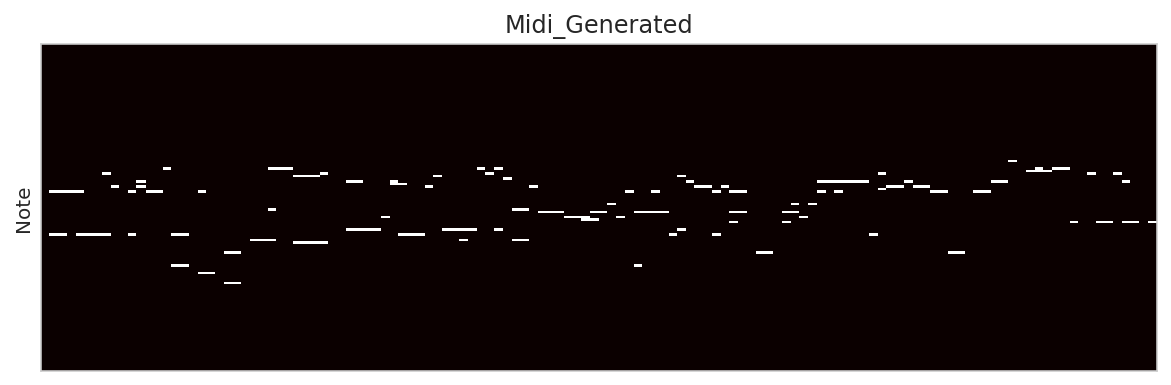

In [ ]:
Play_midi(notes_gen[0,:,:],decode = True,TO_MID=True,FILENAME="/content/test.mid")

It sometimes sounds a bit false but on the other hand, found that it was interesting to see that the generated suond has patterns such as sounding right three notes chords, typically left-hand accompagniement and "songs" at the right-hand

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning:

Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?



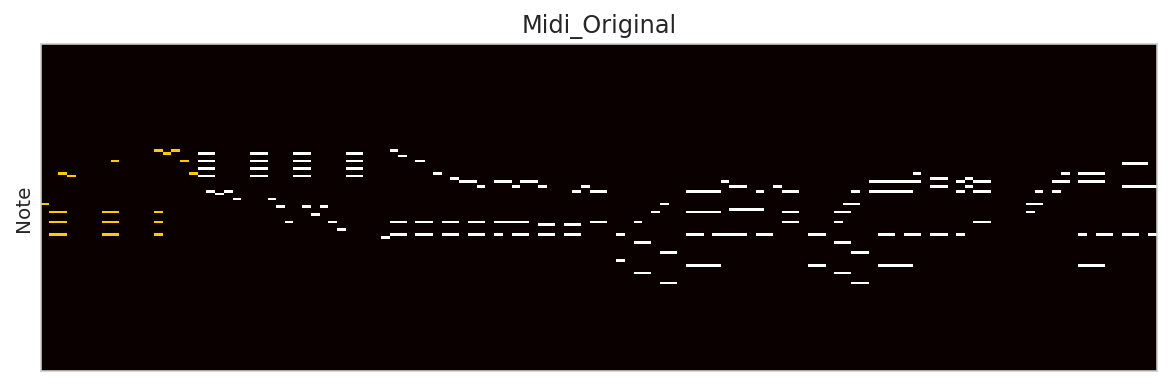

In [ ]:
Play_midi(x[0],decode = False,TO_MID=True,FILENAME="/content/true.mid")

Let's have a look to another sample

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning:

Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?



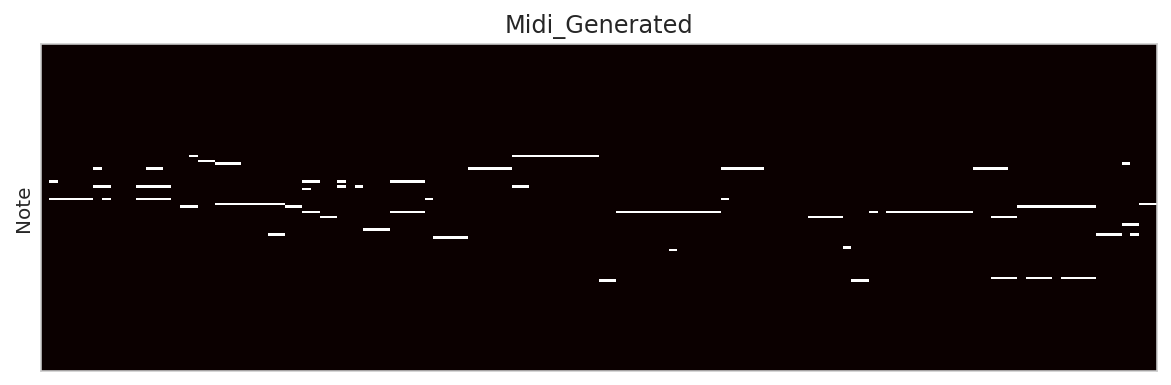

In [ ]:
j = 20
notes_gen = vae.decode_VAE(x[j:j+1], samples[j:j+1],gen_batch=1, NUM_PITCHES = NUM_PITCHES,totalbars = totalbars, notesperbar = notesperbar)
Play_midi(notes_gen[0,:,:],decode = True,TO_MID=True,FILENAME="/content/test_{}.mid".format(j))

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning:

Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?



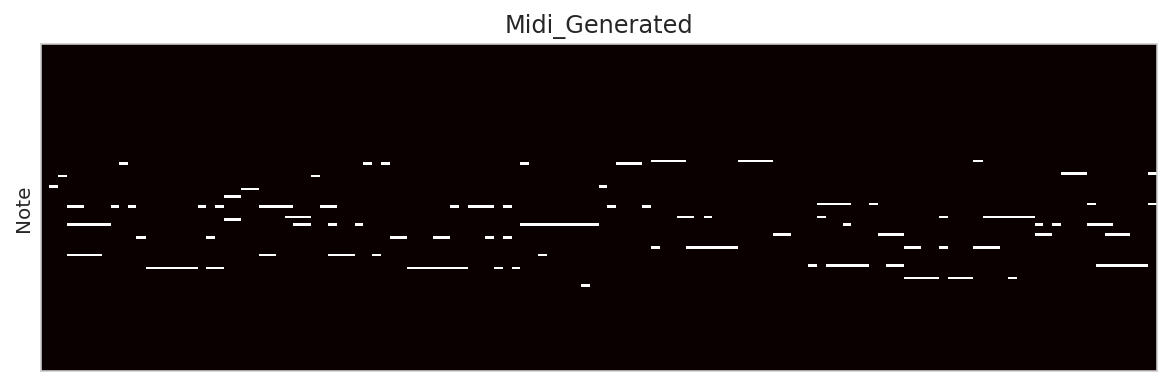

In [ ]:
j = 10
notes_gen = vae.decode_VAE(x[j:j+1], samples[j:j+1],gen_batch=1, NUM_PITCHES = NUM_PITCHES,totalbars = totalbars, notesperbar = notesperbar)
Play_midi(notes_gen[0,:,:],decode = True,TO_MID=True,FILENAME="/content/test_{}.mid".format(j))

In [ ]:
l = []
for j in tqdm.tqdm(range(63)): 
  data_loader = DataLoader(midi_dataset, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)#, sampler=train_sampler)
  x = next(iter(data_loader))
  x = Variable(x['piano_rolls'].type('torch.FloatTensor'))
  notes_gen = vae.decode_VAE(x[30:31], samples[j:j+1],gen_batch=1, NUM_PITCHES = NUM_PITCHES,totalbars = totalbars, notesperbar = notesperbar)
  seq = seq = notes_gen[0,:,:].detach().cpu().numpy()
  out = threshold(seq)
  l.append(pd.DataFrame(np.concatenate([np.arange(len(out)).reshape(-1,1),out],axis=1)))
  






100%|██████████| 63/63 [01:31<00:00,  1.46s/it]


The two samples seems to be quite similar, which is a good new. We have managed to generate a "mozart-sonatas-like" melody. This comment remains however subjective and we would like to improve it by objective criterions of evaluation of our generated music.

# EVALUATION

This following part use evaluation tools to quantify our error during the generation of the modelody.
The following example evaluates the generation of a melodies, with a threshold rule of the maximum along axis (so one single note per time melodies) 

In [12]:
from DL_SBGMproject.utils.utils_eval import *

In [13]:
df= pd.read_csv(data_output_path + 'csv_for_evaluation/piano_rolls_col.csv')
original = pd.read_csv(data_output_path + 'csv_for_evaluation/Original_Midi_encoded.csv',sep=';')
original = original.drop(columns = original.columns[-20:])
original = original.drop(columns = original.columns[2:50])
original.columns = df.columns
gen = pd.read_csv(data_output_path + 'csv_for_evaluation/Generated_Midi_encoded.csv',sep=';')
gen = gen.drop(columns = gen.columns[-20:])
gen = gen.drop(columns = gen.columns[2:50])
gen.columns = df.columns


In [14]:
datasets =  {'dTseqs':[],'tseqs':[], 'pitchseqs':[]}
datasets_or = {'dTseqs':[],'tseqs':[], 'pitchseqs':[]}
datasets = parser_for_eval(gen,datasets)
datasets_or = parser_for_eval(original, datasets_or)

0.03823041588946817

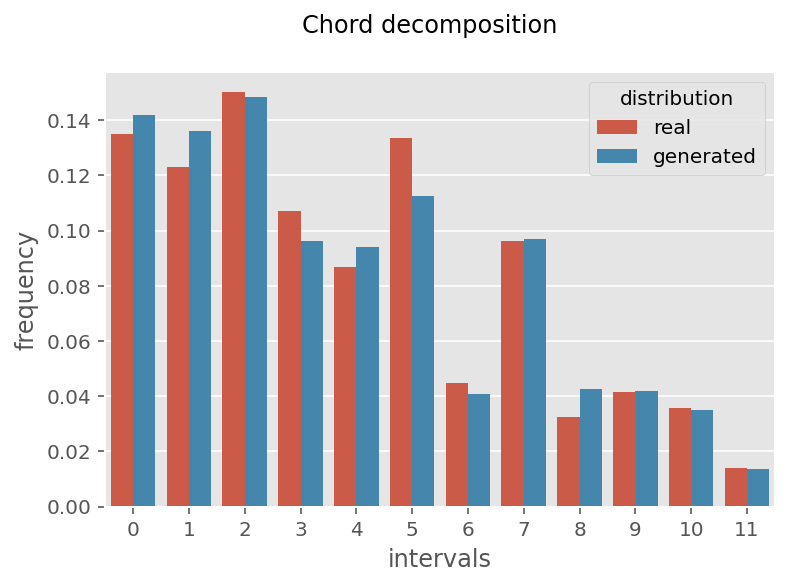

In [15]:
analyze_chords(datasets_or, datasets, show_plot=True)

0.07522749184463201

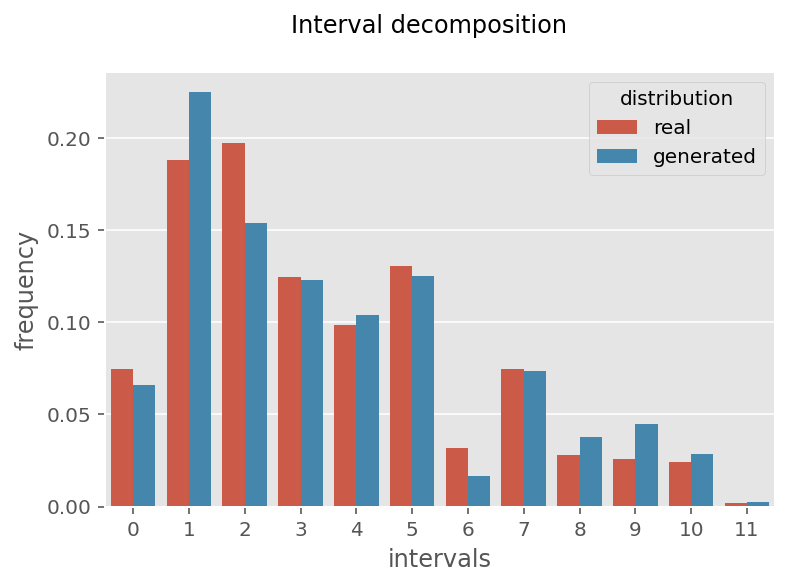

In [16]:
analyze_intervals(datasets_or, datasets, show_plot=True)